# **Basic Example with a Plate**

In this example we model a simply supported beam as a plate, under the effect of a constant distributed load. We run run a linear analysis and do some plotting.

***

### **Create a COM interface to a new instance of AxisVM**

We create a new instance of AxisVM, and make it visible. For the meaning of the argument `daemon=True`, take a look on the docstring of the function.

In [1]:
from axisvm.com.client import start_AxisVM
axvm = start_AxisVM(visible=True, daemon=True)


The type library itself can be imported as

In [2]:
import axisvm.com.tlb as axtlb


If this is not the first time, this import statement can be at the top of the unit.

Create a new model and set the working directory. An empty string means the directory where AxisVM.exe is located:

In [3]:
modelId = axvm.Models.New()
axm = axvm.Models.Item[modelId]
wdir = ""


### **Input data**

When talking about input data, don't forget, that AxisVM internally stores values in $kN$ and $m$.

In [4]:
L = 10.0  # length of the beam
h = 0.02  # height of the cross-section
b = 4.0  # width of the cross section
q = -0.1  # intensity of vertical distributed load


### **Material**

Set Eurocode as the standard and "C16/20" concrete form the material library.

In [5]:
axm.Settings.NationalDesignCode = axtlb.ndcEuroCode
matId = axm.Materials.AddFromCatalog(axtlb.ndcEuroCode, "S 235")


### **Geometry**

The definition of a geometry of a model follows a hierarchical workflow. This means, that we cannot directly define the domains. Instead, we first define the nodes that make up the lines, with which finally we define the domains.

We create the beam as two touching domains, which makes up for a total of 6 nodes. We also store the indices of the defined nodes as a reference for creating the lines.

In [6]:
import numpy as np
from axisvm.com.tlb import dofPlateXY

# the plate is in the x-y plane
coords = np.zeros((4, 3))  # we have four points in 3d space
coords[0, :] = 0., -b/2, 0.
coords[1, :] = L, -b/2, 0.
coords[2, :] = L, b/2, 0.
coords[3, :] = 0., b/2, 0.

fnc = axm.Nodes.AddWithDOF
nodeIDs = list(map(lambda c: fnc(*c, dofPlateXY), coords))


We define the lines that make up the domains and store their indices in a `list`. 

In [7]:
nodes_of_lines = [[0, 1], [1, 2], [2, 3], [3, 0]]
LineGeomType = axtlb.lgtStraightLine
lineIDs = []
for line in nodes_of_lines:
    lineIDs.append(axm.Lines.Add(nodeIDs[line[0]], nodeIDs[line[1]],
                   LineGeomType, axtlb.RLineGeomData())[1])


Now we are in a position to create the domains by providing lineIDs.

In [8]:
from axisvm.com.tlb import RSurfaceAttr, lnlTensionAndCompression, \
    RResistancesXYZ, schLinear, stPlate, RElasticFoundationXYZ, \
    RNonLinearityXYZ, xtldLocalX

sattr = RSurfaceAttr(
    Thickness=h,
    SurfaceType=stPlate,
    RefZId=0,
    RefXId=0,
    MaterialId=matId,
    ElasticFoundation=RElasticFoundationXYZ(0, 0, 0),
    NonLinearity=RNonLinearityXYZ(lnlTensionAndCompression,
                                  lnlTensionAndCompression,
                                  lnlTensionAndCompression),
    Resistance=RResistancesXYZ(0, 0, 0),
    Charactersitics=schLinear)

id = axm.Domains.Add(LineIds=lineIDs, SurfaceAttr=sattr)[1]
#im = axm.XLAMPanels.AddFromCatalog('Binderholz', '3(90)')
#axm.Domains.SetXLAMParameters(id, im, xtldLocalX)


### **Loads**

We add a line load on the whole span of the beam with the specified load intensities.

In [9]:
LoadDomainConstant = axtlb.RLoadDomainConstant(
    LoadCaseId=1, DomainId=1,
    qx=0, qy=0, qz=q,
    DistributionType=axtlb.sddtSurface,
    SystemGLR=axtlb.sysLocal
)
case_1_id = axm.Loads.AddDomainConstant(LoadDomainConstant)


### **Supports**

We add two hinged supports at the ends.

In [10]:
springleft = axtlb.RStiffnesses(
    x=1e12,
    y=1e12,
    z=1e12,
    xx=0,
    yy=0,
    zz=0
)
springright = axtlb.RStiffnesses(
    x=1e12,
    y=1e12,
    z=1e12,
    xx=0,
    yy=0,
    zz=0
)
RNonLinearity = axtlb.RNonLinearity(
    x=axtlb.lnlTensionAndCompression,
    y=axtlb.lnlTensionAndCompression,
    z=axtlb.lnlTensionAndCompression,
    xx=axtlb.lnlTensionAndCompression,
    yy=axtlb.lnlTensionAndCompression,
    zz=axtlb.lnlTensionAndCompression
)
RResistances = axtlb.RResistances(
    x=0,
    y=0,
    z=0,
    xx=0,
    yy=0,
    zz=0
)
_ = axm.LineSupports.AddEdgeGlobal(springleft, RNonLinearity,
                                   RResistances, 2, 0, 0, 1, 0)
_ = axm.LineSupports.AddEdgeGlobal(springright, RNonLinearity,
                                   RResistances, 4, 0, 0, 1, 0)


### **Meshing**

We define a triangle mesh, with a mesh size of $h/2$.

In [11]:
MeshParams = axtlb.RDomainMeshParameters(
    MeshSize=b/10,
    MeshType=axtlb.mtUniform,
    MeshGeometryType=axtlb.mgtTriangle
)
axm.Domains[:].GenerateMesh(MeshParams)


 (),
 (),
 (),
 1]

Notice the use of the semicolon here. This simplifies carrying out the same operation over a range of domains. (the colon at the end simply suppresses the output).

### **Processing**

We save the file and run a linear analysis, with all warnings suppressed.

In [12]:
fpath = wdir + 'ss_beam_P.axs'
axm.SaveToFile(fpath, False)
axm.Calculation.LinearAnalysis(axtlb.cuiNoUserInteractionWithAutoCorrectNoShow)


1

### **Plotting with AxisVM**

We want to plot vertical displacements. At the end we save the plot to a file in the working directory.

In [13]:

# we want the domain to fill up the screen entirely
axm.View = axtlb.vTop
axm.FitInView()

# turn off the grid
GridOptions = axtlb.RGridOptions(DisplayGrid=False)
axm.Settings.SetGridOptions(GridOptions)

WriteValuesTo = axtlb.RWriteValuesTo(
    Nodes=True,
    Lines=True,
    Surfaces=False,
    MinMaxOnly=True
)

BasicDispParams = axtlb.RBasicDisplayParameters_V153(
    ResultComponent=axtlb.rc_d_eZ,
    Scale=1.0,
    DisplayMode=axtlb.dmIsosurfaces2D,
    DisplayShape=axtlb.dsUndeformed,
    WriteValuesTo=WriteValuesTo
)

ExtDispParams = axtlb.RExtendedDisplayParameters_V153(
    BasicDispParams=BasicDispParams,
    DisplayAnalysisType=axtlb.datLinear,
    ResultType=axtlb.rtLoadCase
)
axm.Windows.SetStaticDisplayParameters_V153(1, ExtDispParams, 1, [])

axm.Windows.ReDraw()
imgpath = wdir + 'ss_beam_P_ez.bmp'
axm.Windows[1].SaveWindowToBitmap(axtlb.wcmColour, imgpath)
axvm.BringToFront()


1

In [14]:
axm.Lines[1]


IAxisVMLine,Information
Length,4.000e-01
Volume,0.000e+00
Weight,0.000e+00


In [15]:
axm.Domains[1]


IAxisVMDomain,Information
Name,1
Index,1
UID,1
N Surfaces,590
Area,4.000e+01
Volume,8.000e-01
Weight,6.280e+03


In [16]:
import matplotlib.pyplot as plt

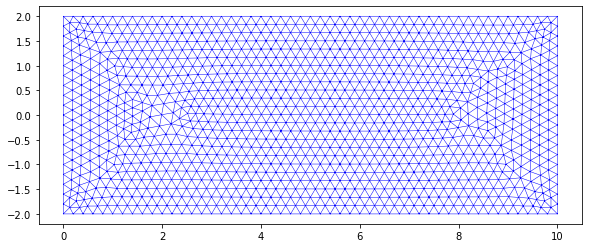

In [17]:
fig, ax = plt.subplots(figsize=(20, 4))
axm.Domains[1].plot(fig=fig, ax=ax)

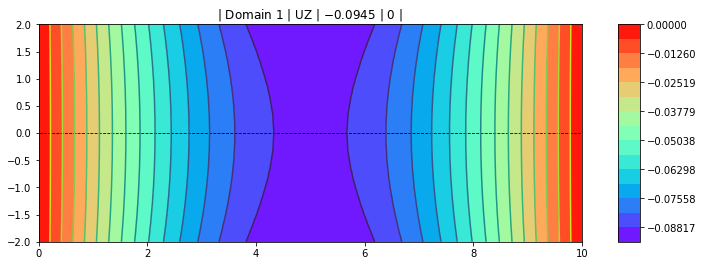

In [18]:
class Cursor:
    """
    A cross hair cursor.
    """
    def __init__(self, ax):
        self.ax = ax
        self.horizontal_line = ax.axhline(color='k', lw=0.8, ls='--')
        self.vertical_line = ax.axvline(color='k', lw=0.8, ls='--')
        # text location in axes coordinates
        self.text = ax.text(0.72, 0.9, '', transform=ax.transAxes)

    def set_cross_hair_visible(self, visible):
        need_redraw = self.horizontal_line.get_visible() != visible
        self.horizontal_line.set_visible(visible)
        self.vertical_line.set_visible(visible)
        self.text.set_visible(visible)
        return need_redraw

    def on_mouse_click(self, event):
        if not event.inaxes:
            need_redraw = self.set_cross_hair_visible(False)
            if need_redraw:
                self.ax.figure.canvas.draw()
        else:
            self.set_cross_hair_visible(True)
            x, y = event.xdata, event.ydata
            # update the line positions
            self.horizontal_line.set_ydata(y)
            self.vertical_line.set_xdata(x)
            self.text.set_text('x=%1.2f, y=%1.2f' % (x, y))
            self.ax.figure.canvas.draw()
    
    def on_mouse_move(self, event):
        if not event.inaxes:
            need_redraw = self.set_cross_hair_visible(False)
            if need_redraw:
                self.ax.figure.canvas.draw()
        else:
            self.set_cross_hair_visible(True)
            x, y = event.xdata, event.ydata
            # update the line positions
            self.horizontal_line.set_ydata(y)
            self.vertical_line.set_xdata(x)
            self.text.set_text('x=%1.2f, y=%1.2f' % (x, y))
            self.ax.figure.canvas.draw()

fig, ax = plt.subplots(figsize=(20, 4))
cursor = Cursor(ax)
#cid_move = fig.canvas.mpl_connect('motion_notify_event', cursor.on_mouse_move)
cid_click = fig.canvas.mpl_connect('button_press_event', cursor.on_mouse_click)

mpl_kw = dict(nlevels=15, cmap='rainbow', axis='on', offset=0., cbpad=0.5,
              cbsize=0.3, cbpos='right', fig=fig, ax=ax)

axm.Domains[1].plot_dof_solution(component='uz', mpl_kw=mpl_kw, case=1)

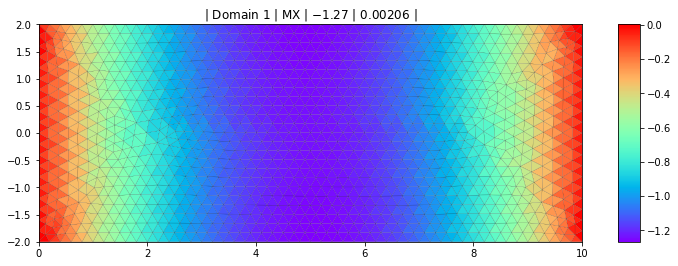

In [19]:
fig, ax = plt.subplots(figsize=(20, 4))
mpl_kw = dict(nlevels=15, cmap='rainbow', axis='on', offset=0., cbpad=0.5,
              cbsize=0.3, cbpos='right', fig=fig, ax=ax)
axm.Domains[1].plot_forces(component='mx', mpl_kw=mpl_kw, case=1)

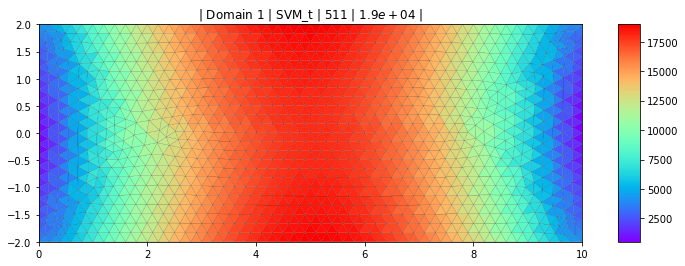

In [22]:
fig, ax = plt.subplots(figsize=(20, 4))
mpl_kw = dict(nlevels=15, cmap='rainbow', axis='on', offset=0., cbpad=0.5,
              cbsize=0.3, cbpos='right', fig=fig, ax=ax)
axm.Domains[1].plot_stresses(component='svm', mpl_kw=mpl_kw, case=1, z='t')

### **Close AxisVM**

Because we created the interface with `daemon=True`, the application closes without any warning.

In [21]:
# axvm.Quit()
